## Agentic RAG

Agentic Retrieval-Augmented Generation (Agentic RAG) is an advanced approach to question answering that goes beyond traditional RAG by introducing intelligent, adaptive strategies for document retrieval and response generation. Unlike standard RAG, which simply retrieves and feeds documents to a language model. In this lesson, we will be using the LangGraph framework to explore how Agentic RAG integrates:

Intelligent Retrieval

Query Rewriting

Document Relevance Grading

Response Generation

#### lets import necessary Libraries

In [1]:
from typing import TypedDict
from typing import Literal
from dotenv import load_dotenv
from langchain_chroma import Chroma
import pandas as pd
from uuid import uuid4
import os
import pathlib
from langchain_together import ChatTogether
from langchain_together import TogetherEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, Sequence, TypedDict
from langchain.tools.retriever import create_retriever_tool


In [2]:
load_dotenv(dotenv_path="./credentials.env")
together_api = os.environ["TOGETHER_API_KEY"]

In [3]:
chroma_dir = pathlib.Path().resolve()
chroma_path = f"{chroma_dir}\\chroma_store"

We will use the same MSME document used for RAG.

In [5]:
msme = pd.read_csv ("msme.csv")
documents = []
metadatas = []
ids = []

for index, row in msme.iterrows():    
    texts = str(row["Content"])
    title = row["Title"]
    sources = row["Sources"]
        
    content = texts
    metadata = {"Source":sources ,  "doc_title": title}
    id = f"{title}-{uuid4()}"

    documents.append(content)
    metadatas.append(metadata)
    ids.append(id)


print(f"Total Documents to be embedded {len(documents)}\n")

Total Documents to be embedded 14



In [5]:
embeddings = TogetherEmbeddings(
    model="togethercomputer/m2-bert-80M-8k-retrieval",
     api_key=together_api
)

Agent_msmevdb = Chroma(
   collection_name="MSME",
   persist_directory=chroma_path, 
   embedding_function= embeddings)

Agent_msmevdb.add_texts(
   texts= documents,
   metadatas=metadatas,
   ids = ids

)

["**Introduction 1. Definition and Importance of MSMEs**    - Definitions according to Nigerian policies (e.g., SMEDAN criteria).    - Role of MSMEs in Nigeria's economy (employment, GDP contribution, innovation).-d331db87-9a79-4081-a8ff-58a1c7d246a1",
 '**Understanding MSMEs in Nigeria** 1. **Overview of the MSME Sector**    - Statistical data (number of MSMEs, sectoral distribution, urban vs. rural).    - Key industries and opportunities.-bc754d25-baad-414e-b979-8b1628ca41ce',
 '**Understanding MSMEs in Nigeria**  2. **Challenges Faced by MSMEs**    - Access to financing.    - Regulatory hurdles.    - Infrastructure deficits.    - Competition and market access.-5f29a218-f13f-40b9-b563-dbe75eaec258',
 '**Understanding MSMEs in Nigeria**3. **Policies and Support Frameworks**    - Government initiatives (e.g., SMEDAN, CBN interventions).    - Available grants and loans (e.g., AGSMEIS, NIRSAL MFB).    - International support programs.-f2d9067f-17e4-44f5-a67a-e6cf7aa7eb1f',
 '**Starting a

#### **Define Agent State**

The Agent state contains a list of messages, which represent interactions between the user and the model.

Allows tracking of query, retrieved documents, and generated responses

In [7]:
# State Definition
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

**Create Retriever Tool**

we are using the create_retriever_tool function from langchain

In [7]:
# Create Retriever Tool
retriever_tool = create_retriever_tool(
Agent_msmevdb.as_retriever(search_type="mmr", search_kwargs={"k":5, "fetch_k": 5}),
    "retrieve_msme_docs",
    "Search and return documents about MSMEs in Nigeria"
)

In [6]:
#initialize the chatmodel
chatmodel = ChatTogether(
    api_key=together_api,
    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    temperature=0
)

 ### Agent Function

The agent function manages workflow interactions.

Tool Binding: we bind the retriever tool to the language model
The Agent  autonomously decide when to use the retrieval tool

messages: User's original question and Subsequent messages inn the Conversation history


In [10]:

def agent(state):
    """Agent node with tool usage"""
    print("--- AGENT PROCESSING---")
    messages = state["messages"]
    # Prepare the model with retriever tool
    model = chatmodel
    Agent_tool = model.bind_tools([retriever_tool])
    # Invoke the model with current messages
    response = Agent_tool.invoke(messages)
    return {"messages": [response]}

### **Document Relevance Grading**

 The agent will access the retrieved documents relevance using an LLM.

  Document Grader → Ensures only relevant documents are used in retrieval-augmented generation (RAG).
 The grader takes in :

 `messages[0]: Original user question`

 `messages[-1]: Retrieved documents content`

This is typically the result from the retriever tool.
 
Return "generate" if documents are relevant.

Returns "rewrite" if documents are not relevant, triggering query refinement

 Prompt  → Shows how to guide LLM behavior with structured instructions.
 Pydantic (Structured Output) → Helps enforce consistent and desired document grading results from the LLM.








In [11]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """Determines document relevance"""
    print("---CHECK DOCUMENTS RELEVANCE---")
    
    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content
    
    class GradeRetriever(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    
    model = chatmodel
    llm_with_doc_grader = model.with_structured_output(GradeRetriever)
    
    prompt = ChatPromptTemplate.from_template(
        """You are a grader assessing relevance of a retrieved document to a user question.
        Here is the retrieved document: {context}
        Here is the user question: {question}
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        Do not add explanatory or introductory lines"""
    )
    
    chain = prompt | llm_with_doc_grader 
    result = chain.invoke({"question": question, "context": docs})
    
    if result.binary_score == "yes":
        print(" Decision : Document is RELEVANT to the question")
    else:
        print(" Decision : Document is NOT RELEVANT to the question")
        
    decision = "generate" if result.binary_score == "yes" else "rewrite"
    return decision

### Query Rewriting

Here we use an llm to  rephrases queries to improve document retrieval when query is not relevant to question.

The query rewriter takes in the messages[0]: Original user question that did not match retrieved documents

In [12]:
def rewrite(state):
    """Rewrite question for better matching"""
    print("---REWRITING  QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    model = chatmodel
    response = model.invoke([
        HumanMessage(content=f"""
    Rephrase this question about MSMEs in Nigeria to improve document retrieval:
    {question}
    Provide a semantically equivalent question that might match available documents.
    Only return the rephrased question, no explanations. If question is not related MSMEs in Nigeria provide feedback
    """)
    ])
    print(f"Rewritten as: {response.content}")
    return {"messages": [response]}


### Answer Generation
The generate  function takes in the :

messages[0]: Original user question AND 

messages[-1]: Retrieved and relevance-checked documents

Uses retrieved context AND question to generate a detailed response.

In [13]:
def generate(state):
    """Generate final answer"""
    print("---GENERATE ANSWER---")
    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content
    
    prompt = ChatPromptTemplate.from_template(
        """You are a business consultant providing insights on MSMEs in Nigeria.
    You will be provided with the context: {context} to answer the user's question.
    The context includes sections on understanding, starting, growing, and sustaining MSMEs, policies, and industry-specific information.
    Provide a detailed and comprehensive response.
    Include relevant sources or links from the context in your response. At the end of each answer, include a statement: "To read more, check out this link: [insert link]."
    Avoid unnecessary or unrelated details. Format the text output clearly and professionally in an HTML format.
    question: {question}"""
    )
    
    chain = (
        prompt | chatmodel| StrOutputParser()
    )
    
    response = chain.invoke({
        "context": docs,
        "question": question
    })
    return {"messages": [HumanMessage(content=response)]}


### Create Workflow Graph

This is to Connect different processing steps / tools / function 

Manages transitions between retrieval, relevance grading, rewriting, and generation



#### Adding Nodes to the Graph

Nodes represent different processing stages.

agent manages workflow logic.

retrieve fetches relevant MSME documents.

rewrite improves query matching.

generate creates the final response.

In [14]:
# Create Graph
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

#### Adding Edges (Transitions)

Edges define the connections between nodes.

**A normal edge** (.add_edg) represents a direct transition from one node to another.

**A conditional edge** (.add_conditional_edges) introduces logic-based transitions:

If the agent needs tools, it moves to retrieve.

Otherwise, it ends the process.




In [15]:
# Add Edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "rewrite": "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

#### Compiling the Graph and Visualizing It

Compiles the workflow for execution.

Visualizes the process using Mermaid Graph.

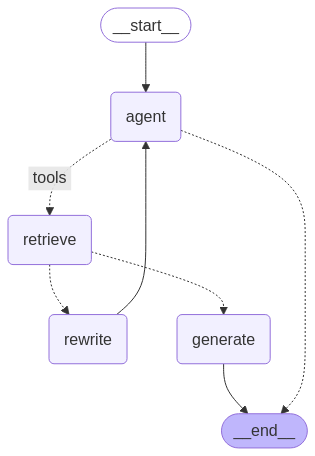

In [16]:
# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

let's use stream to see the output from different nodes gradually instead of generating only the response. 

The Agent processes the query step by step and returns results from each node as they become available.

In [37]:
import pprint
question = "What steps are involved in registering a transport business in Nigeria?"
inputs = {
    "messages": [
        ("user", question),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

--- AGENT PROCESSING---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7ltvuwycdfat4wz2dv3x75h4', 'function': {'arguments': '{"query":"steps involved in registering a transport business in Nigeria"}', 'name': 'retrieve_msme_docs'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 307, 'total_tokens': 332, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c5975d11-bea5-4863-92de-ee0366267e6e-0', tool_calls=[{'name': 'retrieve_msme_docs', 'args': {'query': 'steps involved in registering a transport business in Nigeria'}, 'id': 'call_7ltvuwycdfat4wz2dv3x75h4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 307, 'output_tokens': 25, 'total_tokens': 332, 'input_token_detai

### React Agentic RAG

In this lesson, we will be incoporating a Web Search Tool. This allows us to :

Extend the agent's knowledge beyond static documents

Provide real-time, up-to-date information

Handle queries that fall outside the initial retrieval

Importing Essential Libraries

In [8]:
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

We will be using the Tavily web search tool. Get your Tavily API key from : tavily.com

In [9]:
tavily_api_key = os.getenv("TAVILY_API_KEY")

For this tutorial, we'll use the **Qwen/Qwen2.5-7B-Instruct-Turbo** from Together AI. 

When selecting a model, ensure:

The model supports tool binding

It has good performance with function calling

Important Note: Not all models support tool binding 

In [10]:

model = ChatTogether(model="Qwen/Qwen2.5-7B-Instruct-Turbo", api_key=together_api)

Web Search Function

In [11]:
def search_web(query : str) -> str:
    """search for users query and answer user question"""
    tool = TavilySearchResults(
        max_results=5,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=False,
    )
    context = tool.invoke(query)
    return context

Retriever Tool 

In [12]:
# Create Retriever Tool
retriever_tool = create_retriever_tool(
   Agent_msmevdb.as_retriever(search_type="mmr", search_kwargs={"k":5, "fetch_k": 5}),
    "retrieve_msme_docs",
    "Search and return documents about MSMEs in Nigeria"
)


In [13]:
tools =[search_web, retriever_tool]

Adding Memory to the Agentic RAG
Why Use Memory?

Maintain conversation context
Enable stateful interactions
Track conversation history

Note: Memory is not compulsory but recommended for complex conversations.

In [14]:

memory = MemorySaver()

 Define the Agent Prompt

In [15]:
React_agent_prompt = """ You are an intelligent assistant equipped with two tools:

-Use MSME retriever for Nigeria-specific business insights
-Web Search Tool: use the Web search to look for up-to-date information.
 
 -When a question is related to MSMEs in Nigeria, use the MSME retriever tool
 Provide answers based on the retrieved document context
 Cite specific sources or links  from the retrieved documents

- If the question cannot be answered by the MSME retriever:
  * Automatically use web search tool to find relevant information
  * Provide clear, structured information from web search results """

### ReAct Agent Creation

We will be using the pre built `create_react_agent` function from langchain

The create_react_agent function has several additional parameters that can be implemented depending on your use case. You can explore these options to enhance the agent’s capabilities further.

The agent dynamically decides whether to retrieve documents or search the web


In [ ]:
graph = create_react_agent(
    model= model,
    tools=tools,
     messages_modifier= React_agent_prompt,
    #   checkpointer=memory
   
)

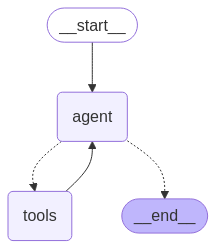

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Testing the Agentic RAG System
USING THE Retriever tool

Example 1: Query on MSMEs in Nigeria 

In [20]:

inputs = {"messages": [("user", "What types of support do governments provide for MSMEs in Nigeria")]}
for s in graph.stream(inputs, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

What types of support do governments provide for MSMEs in Nigeria
================================== Ai Message ==================================
Tool Calls:
  retrieve_msme_docs (call_6old3aumpv77d8uypd63zcva)
 Call ID: call_6old3aumpv77d8uypd63zcva
  Args:
    query: government support for msme in nigeria
================================= Tool Message =================================
Name: retrieve_msme_docs

The Micro, Medium & Small enterprises (“MSME”) sector plays a pivotal role in driving socio-economic growth, particularly in emerging economies. In the Nigerian context, the sector’s status as the largest employer of labour makes it an effective supporting sector for fostering entrepreneurial innovation and local capital formation.  In recognizing the role of MSMEs as the engine for economic growth, the Nigerian government established an agency, the Small and Medium Enterprise Development Agency 

**USING THE WEB SEARCH TOOL**

Example 2: Real time question

In [22]:
inputs = {"messages": [("user", "what time is chelsea playing today, 6th of march 2025?")]}
for s in graph.stream(inputs, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

what time is chelsea playing today, 6th of march 2025?
================================== Ai Message ==================================
Tool Calls:
  search_web (call_xlo4r1z75obkytqesh4maul4)
 Call ID: call_xlo4r1z75obkytqesh4maul4
  Args:
    query: Chelsea FC match schedule 6th March 2025
================================= Tool Message =================================
Name: search_web

[{"title": "March 06, 2025 - The Shed End - Chelsea FC Forums", "url": "https://www.theshedend.com/events/2025/3/6/", "content": "March 06, 2025 · 9:00 · Copenhagen v Chelsea (Europa Conf) Thur 6th March 2025 17:45 GMT.", "score": 0.8943568, "raw_content": "March 06, 2025 - The Shed End - Chelsea FC Forums\nJump to content\n \n\n\nSign In\n\n\nHome \n\nEvents \n\n \n\nForums\nEvents\nDonations\nBrowse\nSubscriptions\nGuidelines\nPrivacy Policy\nStaff\nLeaderboard\nOnline Users\n\n\nActivity\nAll Activity\nSearch\n\n\nCon

### Exercises
**Task 1**: Create an Agentic RAG system that:

Retrieves documents from a knowledge base

Grades document relevance

Generates an answer

Grades the answer's relevance and accuracy


**Task 2**: Create a simple Agentic / React Agent RAG system with the following requirements:

Use a pre-trained language model that supports tool binding 

Implement at least two tools:

Document Retrieval Tool
and any other tool of your choice

use any data of your choice